# **CNN** *Pytorch*

### **Imports...**

In [2]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import random_split
from sklearn.metrics import classification_report

/Users/rasmushelviglarsen/miniforge3/envs/IntelligentSystems/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rasmushelviglarsen/miniforge3/envs/IntelligentSystems/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <367D4265-B20F-34BD-94EB-4F3EE47C385B> /Users/rasmushelviglarsen/miniforge3/envs/IntelligentSystems/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/Users/rasmushelviglarsen/miniforge3/envs/IntelligentSystems/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/rasmushelviglarsen/miniforge3/envs/IntelligentSystems/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/rasmushelviglarsen/miniforge3/envs/IntelligentSystems/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/rasmushelviglarsen/miniforge3/envs/Intelligent

### **GPU/MPS/CPU...**

In [3]:
if torch.cuda.is_available(): 
    device = "cuda"
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = "cpu"
print(
    f"~~~~~~~~~~~~~~~~~ \n"
    f"Using device: {device} \n"
    f"~~~~~~~~~~~~~~~~~")

~~~~~~~~~~~~~~~~~ 
Using device: mps 
~~~~~~~~~~~~~~~~~


### **CNN...**

In [4]:

class CNN(nn.Module):
    def __init__(self, in_channels, num_classes=26): 
       
        super(CNN, self).__init__()

        #1ST CONVOLUTIONAL LAYER
        self.conv1 = nn.Conv2d( 
            in_channels=in_channels,  
            out_channels=64, 
            kernel_size=3, 
            stride=1,  
            padding=1) 
        self.bn1 = nn.BatchNorm2d(64)
        
        #2ND CONVOLUTIONAL LAYER
        self.conv2 = nn.Conv2d(  
            in_channels=64,  
            out_channels=128, 
            kernel_size=3, 
            stride=1, 
            padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        #3RD CONVOLUTIONAL LAYER
        self.conv3 = nn.Conv2d(
            in_channels = 128,
            out_channels = 256,
            kernel_size = 3,
            stride = 1,
            padding = 1)
        self.bn3 = nn.BatchNorm2d(256)
        
        #POOLING LAYER
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #DROPOUT LAYER (FOR REGULARIZATION)
        self.drop_conv = nn.Dropout2d(p=0.2)
        self.drop_fc = nn.Dropout(p=0.5) 
        
        #FULLY CONNECTED LAYER
        self.adap = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(256, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x))) 
        x = self.pool(x) 
        x = self.drop_conv(x)          

        x = F.relu(self.bn2(self.conv2(x)))  
        x = self.pool(x)
        x = self.drop_conv(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.drop_conv(x)

        x = self.adap(x)
        x = x.view(x.size(0),-1)

        x = F.relu(self.fc1(x))
        x = self.drop_fc(x)       
        x = self.fc2(x)            

        return x

### **Hyperparamethers...**

In [5]:
num_classes = 26 
learning_rate = 0.005
batch_size = 200
num_epochs = 100
weight_decay = 0

### **Data loading, preprocessing and transforming...**

In [6]:
def emnist_rotation(img):
    img = img.rotate(-90, expand = True)
    img = img.transpose(Image.FLIP_TOP_BOTTOM)
    return img

def train_transform():
    return transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((32,32),antialias=True), 
    transforms.Lambda(emnist_rotation),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1), scale=(0.9,1.1), shear = 3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307],std=[0.3081])])

def test_transform():
    return transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32,32),antialias=True),
    transforms.Lambda(emnist_rotation),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307],std=[0.3081])])

# ~~~~~~~~~~ SPLITTING THE TRAINING SET ~~~~~~~~~~~
train_base = datasets.EMNIST(root='emnist-letters-train', split='letters', train=True, download=True, transform=test_transform(), target_transform=lambda y: y-1)
train_set = int(0.8*len(train_base))
val_set = len(train_base)-train_set
train_dataset, val_dataset = random_split(train_base, [train_set,val_set])

# ~~~~~~~~~~ TRAIN ~~~~~~~~~~~
train_dataset.dataset.transform = train_transform()
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# ~~~~~~~~~~ VALIDATION ~~~~~~~~~~~
val_dataset.dataset.transform = test_transform()
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

# ~~~~~~~~~~ TEST ~~~~~~~~~~~
test_dataset = datasets.EMNIST(root='emnist-letters-test', split='letters', train=False, download=True, transform=test_transform(), target_transform=lambda y: y-1)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### **Initialize network with loss and optimizer...**

In [6]:
model = CNN(in_channels=1, num_classes=num_classes).to(device)

In [7]:
criterion = nn.CrossEntropyLoss(label_smoothing= 0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

### **Train and evaluate...**

In [8]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}")

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # TRAINING 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    model.train()
    train_correct, train_total, train_loss = 0, 0, 0.0

    for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        scores = model(data) # Forward
        loss = criterion(scores, targets)

        loss.backward() # Backward
        optimizer.step()

        batch_size = targets.size(0)
        train_loss += loss.item() * batch_size
        
        _, preds = scores.max(1)
        train_correct += (preds == targets).sum().item()
        train_total += batch_size
    
    train_loss /= train_total
    train_acc = 100.0 * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # EVALUATION 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    model.eval()
    val_correct, val_total, val_loss = 0, 0, 0.0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            scores = model(x)
            
            loss = criterion(scores, y)
            batch_size = y.size(0)
            val_loss += loss.item() * batch_size

            _, predictions = scores.max(1) 
            val_correct += (predictions == y).sum().item() 
            val_total += batch_size

    val_loss /= val_total
    val_acc = float(val_correct) / float(val_total) * 100.0
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
        
    print(
        f" \n "
        f"|~|TRAINING:|~| Accuracy: {train_acc:.2f}, Loss: {train_loss:.4f}. \n "
        f"|~|EVALUATING:|~| Accuracy: {val_acc:.2f}, Loss: {val_loss:.4f}. \n " 
        f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~"
        )
    print()

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# FINAL METRICS 
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
final_train_loss = train_losses[-1]
final_train_acc = train_accuracies[-1]
final_val_loss = val_losses[-1]
final_val_acc = val_accuracies[-1]

print("===== Training Complete =====")
print(f"Final Train Loss: {final_train_loss:.4f}")
print(f"Final Train Accuracy: {final_train_acc:.2f}%")
print(f"Final Test Loss: {final_val_loss:.4f}")
print(f"Final Test Accuracy: {final_val_acc:.2f}%")
    

Epoch [1/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:26<00:00, 18.75it/s]


 
 |~|TRAINING:|~| Accuracy: 57.57, Loss: 1.3307. 
 |~|EVALUATING:|~| Accuracy: 87.40, Loss: 0.4000. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [2/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.44it/s]


 
 |~|TRAINING:|~| Accuracy: 83.24, Loss: 0.5261. 
 |~|EVALUATING:|~| Accuracy: 91.44, Loss: 0.2552. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [3/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:24<00:00, 20.45it/s]


 
 |~|TRAINING:|~| Accuracy: 87.47, Loss: 0.3913. 
 |~|EVALUATING:|~| Accuracy: 92.55, Loss: 0.2179. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [4/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.30it/s]


 
 |~|TRAINING:|~| Accuracy: 89.36, Loss: 0.3349. 
 |~|EVALUATING:|~| Accuracy: 93.09, Loss: 0.2000. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [5/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.53it/s]


 
 |~|TRAINING:|~| Accuracy: 90.26, Loss: 0.3031. 
 |~|EVALUATING:|~| Accuracy: 93.16, Loss: 0.1864. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [6/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:24<00:00, 20.69it/s]


 
 |~|TRAINING:|~| Accuracy: 90.90, Loss: 0.2820. 
 |~|EVALUATING:|~| Accuracy: 93.37, Loss: 0.1854. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [7/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.23it/s]


 
 |~|TRAINING:|~| Accuracy: 91.29, Loss: 0.2662. 
 |~|EVALUATING:|~| Accuracy: 93.97, Loss: 0.1752. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [8/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.49it/s]


 
 |~|TRAINING:|~| Accuracy: 91.77, Loss: 0.2517. 
 |~|EVALUATING:|~| Accuracy: 93.82, Loss: 0.1777. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [9/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.26it/s]


 
 |~|TRAINING:|~| Accuracy: 92.15, Loss: 0.2411. 
 |~|EVALUATING:|~| Accuracy: 94.17, Loss: 0.1722. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [10/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.49it/s]


 
 |~|TRAINING:|~| Accuracy: 92.22, Loss: 0.2338. 
 |~|EVALUATING:|~| Accuracy: 94.09, Loss: 0.1721. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [11/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:22<00:00, 21.81it/s]


 
 |~|TRAINING:|~| Accuracy: 92.50, Loss: 0.2273. 
 |~|EVALUATING:|~| Accuracy: 94.46, Loss: 0.1657. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [12/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:22<00:00, 21.81it/s]


 
 |~|TRAINING:|~| Accuracy: 92.70, Loss: 0.2186. 
 |~|EVALUATING:|~| Accuracy: 94.31, Loss: 0.1683. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [13/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:22<00:00, 21.82it/s]


 
 |~|TRAINING:|~| Accuracy: 92.90, Loss: 0.2113. 
 |~|EVALUATING:|~| Accuracy: 94.49, Loss: 0.1614. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [14/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.41it/s]


 
 |~|TRAINING:|~| Accuracy: 92.93, Loss: 0.2098. 
 |~|EVALUATING:|~| Accuracy: 94.50, Loss: 0.1639. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [15/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:22<00:00, 21.84it/s]


 
 |~|TRAINING:|~| Accuracy: 93.06, Loss: 0.2063. 
 |~|EVALUATING:|~| Accuracy: 94.65, Loss: 0.1612. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [16/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 20.92it/s]


 
 |~|TRAINING:|~| Accuracy: 93.24, Loss: 0.1989. 
 |~|EVALUATING:|~| Accuracy: 94.44, Loss: 0.1625. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [17/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:24<00:00, 20.65it/s]


 
 |~|TRAINING:|~| Accuracy: 93.38, Loss: 0.1943. 
 |~|EVALUATING:|~| Accuracy: 94.66, Loss: 0.1608. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [18/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.30it/s]


 
 |~|TRAINING:|~| Accuracy: 93.52, Loss: 0.1928. 
 |~|EVALUATING:|~| Accuracy: 94.56, Loss: 0.1697. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [19/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:28<00:00, 17.61it/s]


 
 |~|TRAINING:|~| Accuracy: 93.52, Loss: 0.1900. 
 |~|EVALUATING:|~| Accuracy: 94.54, Loss: 0.1668. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [20/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:24<00:00, 20.16it/s]


 
 |~|TRAINING:|~| Accuracy: 93.71, Loss: 0.1838. 
 |~|EVALUATING:|~| Accuracy: 94.49, Loss: 0.1701. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [21/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:26<00:00, 19.05it/s]


 
 |~|TRAINING:|~| Accuracy: 93.71, Loss: 0.1832. 
 |~|EVALUATING:|~| Accuracy: 94.66, Loss: 0.1625. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [22/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.22it/s]


 
 |~|TRAINING:|~| Accuracy: 93.89, Loss: 0.1796. 
 |~|EVALUATING:|~| Accuracy: 94.81, Loss: 0.1604. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [23/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.47it/s]


 
 |~|TRAINING:|~| Accuracy: 93.94, Loss: 0.1766. 
 |~|EVALUATING:|~| Accuracy: 94.62, Loss: 0.1641. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [24/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:57<00:00,  8.74it/s]


 
 |~|TRAINING:|~| Accuracy: 93.91, Loss: 0.1742. 
 |~|EVALUATING:|~| Accuracy: 94.57, Loss: 0.1648. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [25/100]
Learning rate: 0.005000


100%|██████████| 500/500 [01:23<00:00,  6.02it/s]


 
 |~|TRAINING:|~| Accuracy: 94.05, Loss: 0.1725. 
 |~|EVALUATING:|~| Accuracy: 94.70, Loss: 0.1621. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [26/100]
Learning rate: 0.005000


100%|██████████| 500/500 [01:34<00:00,  5.28it/s]


 
 |~|TRAINING:|~| Accuracy: 94.04, Loss: 0.1693. 
 |~|EVALUATING:|~| Accuracy: 94.78, Loss: 0.1647. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [27/100]
Learning rate: 0.005000


100%|██████████| 500/500 [01:34<00:00,  5.27it/s]


 
 |~|TRAINING:|~| Accuracy: 94.14, Loss: 0.1675. 
 |~|EVALUATING:|~| Accuracy: 94.64, Loss: 0.1626. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [28/100]
Learning rate: 0.005000


100%|██████████| 500/500 [01:25<00:00,  5.82it/s]


 
 |~|TRAINING:|~| Accuracy: 94.19, Loss: 0.1653. 
 |~|EVALUATING:|~| Accuracy: 94.61, Loss: 0.1647. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [29/100]
Learning rate: 0.005000


100%|██████████| 500/500 [01:34<00:00,  5.32it/s]


 
 |~|TRAINING:|~| Accuracy: 94.24, Loss: 0.1641. 
 |~|EVALUATING:|~| Accuracy: 94.66, Loss: 0.1684. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [30/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:35<00:00, 14.09it/s]


 
 |~|TRAINING:|~| Accuracy: 94.31, Loss: 0.1604. 
 |~|EVALUATING:|~| Accuracy: 94.62, Loss: 0.1722. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [31/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:45<00:00, 10.95it/s]


 
 |~|TRAINING:|~| Accuracy: 94.37, Loss: 0.1582. 
 |~|EVALUATING:|~| Accuracy: 94.62, Loss: 0.1724. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [32/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:48<00:00, 10.41it/s]


 
 |~|TRAINING:|~| Accuracy: 94.48, Loss: 0.1551. 
 |~|EVALUATING:|~| Accuracy: 94.86, Loss: 0.1675. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [33/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:46<00:00, 10.76it/s]


 
 |~|TRAINING:|~| Accuracy: 94.41, Loss: 0.1568. 
 |~|EVALUATING:|~| Accuracy: 94.78, Loss: 0.1696. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [34/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:47<00:00, 10.51it/s]


 
 |~|TRAINING:|~| Accuracy: 94.51, Loss: 0.1551. 
 |~|EVALUATING:|~| Accuracy: 94.77, Loss: 0.1665. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [35/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:46<00:00, 10.81it/s]


 
 |~|TRAINING:|~| Accuracy: 94.58, Loss: 0.1514. 
 |~|EVALUATING:|~| Accuracy: 94.92, Loss: 0.1693. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [36/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:33<00:00, 14.74it/s]


 
 |~|TRAINING:|~| Accuracy: 94.60, Loss: 0.1512. 
 |~|EVALUATING:|~| Accuracy: 94.65, Loss: 0.1768. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [37/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:27<00:00, 18.27it/s]


 
 |~|TRAINING:|~| Accuracy: 94.70, Loss: 0.1478. 
 |~|EVALUATING:|~| Accuracy: 94.78, Loss: 0.1663. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [38/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.26it/s]


 
 |~|TRAINING:|~| Accuracy: 94.65, Loss: 0.1491. 
 |~|EVALUATING:|~| Accuracy: 94.64, Loss: 0.1715. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [39/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.11it/s]


 
 |~|TRAINING:|~| Accuracy: 94.77, Loss: 0.1464. 
 |~|EVALUATING:|~| Accuracy: 94.88, Loss: 0.1639. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [40/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.16it/s]


 
 |~|TRAINING:|~| Accuracy: 94.74, Loss: 0.1438. 
 |~|EVALUATING:|~| Accuracy: 94.71, Loss: 0.1762. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [41/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.20it/s]


 
 |~|TRAINING:|~| Accuracy: 94.75, Loss: 0.1437. 
 |~|EVALUATING:|~| Accuracy: 94.88, Loss: 0.1666. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [42/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.39it/s]


 
 |~|TRAINING:|~| Accuracy: 94.88, Loss: 0.1419. 
 |~|EVALUATING:|~| Accuracy: 94.78, Loss: 0.1781. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [43/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:24<00:00, 20.72it/s]


 
 |~|TRAINING:|~| Accuracy: 94.81, Loss: 0.1431. 
 |~|EVALUATING:|~| Accuracy: 94.92, Loss: 0.1696. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [44/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:24<00:00, 20.73it/s]


 
 |~|TRAINING:|~| Accuracy: 94.91, Loss: 0.1395. 
 |~|EVALUATING:|~| Accuracy: 94.65, Loss: 0.1746. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [45/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.25it/s]


 
 |~|TRAINING:|~| Accuracy: 94.84, Loss: 0.1401. 
 |~|EVALUATING:|~| Accuracy: 94.86, Loss: 0.1755. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [46/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.27it/s]


 
 |~|TRAINING:|~| Accuracy: 94.90, Loss: 0.1378. 
 |~|EVALUATING:|~| Accuracy: 94.65, Loss: 0.1784. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [47/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:30<00:00, 16.46it/s]


 
 |~|TRAINING:|~| Accuracy: 94.93, Loss: 0.1363. 
 |~|EVALUATING:|~| Accuracy: 94.65, Loss: 0.1759. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [48/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.29it/s]


 
 |~|TRAINING:|~| Accuracy: 94.97, Loss: 0.1361. 
 |~|EVALUATING:|~| Accuracy: 94.87, Loss: 0.1748. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [49/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.47it/s]


 
 |~|TRAINING:|~| Accuracy: 95.01, Loss: 0.1351. 
 |~|EVALUATING:|~| Accuracy: 94.88, Loss: 0.1756. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [50/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.48it/s]


 
 |~|TRAINING:|~| Accuracy: 94.96, Loss: 0.1349. 
 |~|EVALUATING:|~| Accuracy: 94.99, Loss: 0.1724. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [51/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.40it/s]


 
 |~|TRAINING:|~| Accuracy: 95.05, Loss: 0.1363. 
 |~|EVALUATING:|~| Accuracy: 94.80, Loss: 0.1818. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [52/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.04it/s]


 
 |~|TRAINING:|~| Accuracy: 95.08, Loss: 0.1332. 
 |~|EVALUATING:|~| Accuracy: 94.85, Loss: 0.1766. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [53/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.53it/s]


 
 |~|TRAINING:|~| Accuracy: 95.05, Loss: 0.1343. 
 |~|EVALUATING:|~| Accuracy: 94.83, Loss: 0.1739. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [54/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.28it/s]


 
 |~|TRAINING:|~| Accuracy: 95.15, Loss: 0.1317. 
 |~|EVALUATING:|~| Accuracy: 94.77, Loss: 0.1756. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [55/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:22<00:00, 21.75it/s]


 
 |~|TRAINING:|~| Accuracy: 95.25, Loss: 0.1295. 
 |~|EVALUATING:|~| Accuracy: 94.86, Loss: 0.1817. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [56/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:22<00:00, 21.86it/s]


 
 |~|TRAINING:|~| Accuracy: 95.13, Loss: 0.1304. 
 |~|EVALUATING:|~| Accuracy: 94.81, Loss: 0.1797. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [57/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:22<00:00, 21.82it/s]


 
 |~|TRAINING:|~| Accuracy: 95.27, Loss: 0.1281. 
 |~|EVALUATING:|~| Accuracy: 94.84, Loss: 0.1797. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [58/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:22<00:00, 21.81it/s]


 
 |~|TRAINING:|~| Accuracy: 95.26, Loss: 0.1277. 
 |~|EVALUATING:|~| Accuracy: 94.74, Loss: 0.1860. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [59/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:22<00:00, 21.84it/s]


 
 |~|TRAINING:|~| Accuracy: 95.24, Loss: 0.1280. 
 |~|EVALUATING:|~| Accuracy: 94.70, Loss: 0.1841. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [60/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:22<00:00, 21.85it/s]


 
 |~|TRAINING:|~| Accuracy: 95.33, Loss: 0.1267. 
 |~|EVALUATING:|~| Accuracy: 94.99, Loss: 0.1836. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [61/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 20.90it/s]


 
 |~|TRAINING:|~| Accuracy: 95.21, Loss: 0.1296. 
 |~|EVALUATING:|~| Accuracy: 94.88, Loss: 0.1810. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [62/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:22<00:00, 21.82it/s]


 
 |~|TRAINING:|~| Accuracy: 95.27, Loss: 0.1271. 
 |~|EVALUATING:|~| Accuracy: 94.93, Loss: 0.1847. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [63/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:22<00:00, 21.84it/s]


 
 |~|TRAINING:|~| Accuracy: 95.24, Loss: 0.1265. 
 |~|EVALUATING:|~| Accuracy: 94.77, Loss: 0.1822. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [64/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:24<00:00, 20.58it/s]


 
 |~|TRAINING:|~| Accuracy: 95.35, Loss: 0.1250. 
 |~|EVALUATING:|~| Accuracy: 94.91, Loss: 0.1821. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [65/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.71it/s]


 
 |~|TRAINING:|~| Accuracy: 95.33, Loss: 0.1225. 
 |~|EVALUATING:|~| Accuracy: 95.03, Loss: 0.1840. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [66/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:22<00:00, 21.84it/s]


 
 |~|TRAINING:|~| Accuracy: 95.36, Loss: 0.1221. 
 |~|EVALUATING:|~| Accuracy: 94.92, Loss: 0.1854. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [67/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:22<00:00, 21.79it/s]


 
 |~|TRAINING:|~| Accuracy: 95.38, Loss: 0.1229. 
 |~|EVALUATING:|~| Accuracy: 94.83, Loss: 0.1846. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [68/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.49it/s]


 
 |~|TRAINING:|~| Accuracy: 95.37, Loss: 0.1228. 
 |~|EVALUATING:|~| Accuracy: 94.89, Loss: 0.1838. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [69/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:22<00:00, 21.90it/s]


 
 |~|TRAINING:|~| Accuracy: 95.39, Loss: 0.1210. 
 |~|EVALUATING:|~| Accuracy: 94.88, Loss: 0.1856. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [70/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:25<00:00, 19.53it/s]


 
 |~|TRAINING:|~| Accuracy: 95.40, Loss: 0.1204. 
 |~|EVALUATING:|~| Accuracy: 94.88, Loss: 0.1882. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [71/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:31<00:00, 15.98it/s]


 
 |~|TRAINING:|~| Accuracy: 95.49, Loss: 0.1178. 
 |~|EVALUATING:|~| Accuracy: 94.76, Loss: 0.1884. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [72/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:24<00:00, 20.18it/s]


 
 |~|TRAINING:|~| Accuracy: 95.38, Loss: 0.1233. 
 |~|EVALUATING:|~| Accuracy: 94.70, Loss: 0.1931. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [73/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:24<00:00, 20.55it/s]


 
 |~|TRAINING:|~| Accuracy: 95.49, Loss: 0.1189. 
 |~|EVALUATING:|~| Accuracy: 94.91, Loss: 0.1932. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [74/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.59it/s]


 
 |~|TRAINING:|~| Accuracy: 95.55, Loss: 0.1193. 
 |~|EVALUATING:|~| Accuracy: 94.75, Loss: 0.1907. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [75/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.58it/s]


 
 |~|TRAINING:|~| Accuracy: 95.54, Loss: 0.1178. 
 |~|EVALUATING:|~| Accuracy: 94.76, Loss: 0.1905. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [76/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.60it/s]


 
 |~|TRAINING:|~| Accuracy: 95.65, Loss: 0.1143. 
 |~|EVALUATING:|~| Accuracy: 94.58, Loss: 0.1981. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [77/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.61it/s]


 
 |~|TRAINING:|~| Accuracy: 95.47, Loss: 0.1176. 
 |~|EVALUATING:|~| Accuracy: 94.84, Loss: 0.1923. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [78/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:24<00:00, 20.63it/s]


 
 |~|TRAINING:|~| Accuracy: 95.62, Loss: 0.1169. 
 |~|EVALUATING:|~| Accuracy: 94.81, Loss: 0.1928. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [79/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.21it/s]


 
 |~|TRAINING:|~| Accuracy: 95.57, Loss: 0.1171. 
 |~|EVALUATING:|~| Accuracy: 94.76, Loss: 0.1915. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [80/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.32it/s]


 
 |~|TRAINING:|~| Accuracy: 95.56, Loss: 0.1155. 
 |~|EVALUATING:|~| Accuracy: 94.85, Loss: 0.1871. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [81/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.31it/s]


 
 |~|TRAINING:|~| Accuracy: 95.57, Loss: 0.1164. 
 |~|EVALUATING:|~| Accuracy: 94.82, Loss: 0.1867. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [82/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.35it/s]


 
 |~|TRAINING:|~| Accuracy: 95.67, Loss: 0.1139. 
 |~|EVALUATING:|~| Accuracy: 94.85, Loss: 0.2003. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [83/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.47it/s]


 
 |~|TRAINING:|~| Accuracy: 95.58, Loss: 0.1157. 
 |~|EVALUATING:|~| Accuracy: 94.85, Loss: 0.1946. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [84/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.42it/s]


 
 |~|TRAINING:|~| Accuracy: 95.69, Loss: 0.1133. 
 |~|EVALUATING:|~| Accuracy: 94.86, Loss: 0.2032. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [85/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 20.90it/s]


 
 |~|TRAINING:|~| Accuracy: 95.68, Loss: 0.1126. 
 |~|EVALUATING:|~| Accuracy: 94.81, Loss: 0.1957. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [86/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.19it/s]


 
 |~|TRAINING:|~| Accuracy: 95.63, Loss: 0.1165. 
 |~|EVALUATING:|~| Accuracy: 94.73, Loss: 0.1925. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [87/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.36it/s]


 
 |~|TRAINING:|~| Accuracy: 95.64, Loss: 0.1125. 
 |~|EVALUATING:|~| Accuracy: 94.67, Loss: 0.1994. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [88/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.36it/s]


 
 |~|TRAINING:|~| Accuracy: 95.67, Loss: 0.1127. 
 |~|EVALUATING:|~| Accuracy: 94.81, Loss: 0.1985. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [89/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 20.84it/s]


 
 |~|TRAINING:|~| Accuracy: 95.82, Loss: 0.1105. 
 |~|EVALUATING:|~| Accuracy: 94.95, Loss: 0.1907. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [90/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 20.95it/s]


 
 |~|TRAINING:|~| Accuracy: 95.73, Loss: 0.1106. 
 |~|EVALUATING:|~| Accuracy: 94.96, Loss: 0.1938. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [91/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.41it/s]


 
 |~|TRAINING:|~| Accuracy: 95.75, Loss: 0.1128. 
 |~|EVALUATING:|~| Accuracy: 94.78, Loss: 0.1979. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [92/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.65it/s]


 
 |~|TRAINING:|~| Accuracy: 95.82, Loss: 0.1114. 
 |~|EVALUATING:|~| Accuracy: 94.95, Loss: 0.1969. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [93/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.53it/s]


 
 |~|TRAINING:|~| Accuracy: 95.70, Loss: 0.1116. 
 |~|EVALUATING:|~| Accuracy: 94.76, Loss: 0.2001. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [94/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.14it/s]


 
 |~|TRAINING:|~| Accuracy: 95.74, Loss: 0.1111. 
 |~|EVALUATING:|~| Accuracy: 94.95, Loss: 0.1920. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [95/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.52it/s]


 
 |~|TRAINING:|~| Accuracy: 95.80, Loss: 0.1083. 
 |~|EVALUATING:|~| Accuracy: 94.92, Loss: 0.2038. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [96/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.34it/s]


 
 |~|TRAINING:|~| Accuracy: 95.88, Loss: 0.1052. 
 |~|EVALUATING:|~| Accuracy: 94.88, Loss: 0.2002. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [97/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.58it/s]


 
 |~|TRAINING:|~| Accuracy: 95.94, Loss: 0.1066. 
 |~|EVALUATING:|~| Accuracy: 94.98, Loss: 0.2016. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [98/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.28it/s]


 
 |~|TRAINING:|~| Accuracy: 95.86, Loss: 0.1077. 
 |~|EVALUATING:|~| Accuracy: 94.93, Loss: 0.1956. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [99/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.25it/s]


 
 |~|TRAINING:|~| Accuracy: 95.87, Loss: 0.1072. 
 |~|EVALUATING:|~| Accuracy: 94.57, Loss: 0.2069. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [100/100]
Learning rate: 0.005000


100%|██████████| 500/500 [00:23<00:00, 21.15it/s]


 
 |~|TRAINING:|~| Accuracy: 95.80, Loss: 0.1093. 
 |~|EVALUATING:|~| Accuracy: 94.72, Loss: 0.2056. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

===== Training Complete =====
Final Train Loss: 0.1093
Final Train Accuracy: 95.80%
Final Test Loss: 0.2056
Final Test Accuracy: 94.72%


In [9]:
torch.save(model.state_dict(), "my_CNN.pth")

### **Plotting...**

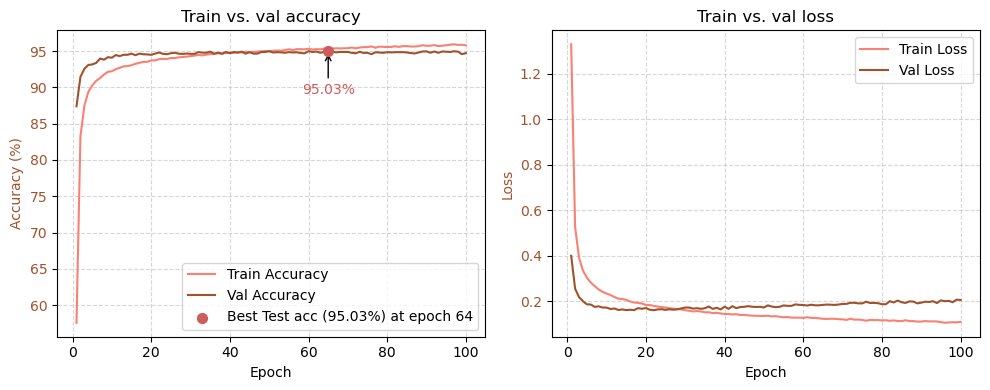

In [10]:
def plot_stats(train_acc, val_acc, train_loss, val_loss):
    epochs = range(1, len(train_acc)+1)
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

    best_epoch = val_acc.index(max(val_acc))
    best_acc = val_acc[best_epoch]

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ACCURACY PLOT 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ax1.plot(epochs, train_acc, label="Train Accuracy", color='salmon')
    ax1.plot(epochs, val_acc, label="Val Accuracy", color='sienna')

    ax1.scatter(best_epoch + 1, best_acc, color='indianred', s=50, zorder=5, label=f"Best Test acc ({best_acc:.2f}%) at epoch {best_epoch}")
    ax1.annotate(f'{best_acc:.2f}%',
                 xy=(best_epoch + 1, best_acc),
                 xytext=(best_epoch + 1, best_acc - 6),
                 ha='center', color='indianred',
                 arrowprops=dict(arrowstyle='->', color='black'))
    ax1.set_title('Train vs. val accuracy')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy (%)", color='Sienna')
    ax1.tick_params(axis='y', labelcolor='Sienna')
    ax1.legend(loc='lower right')
    ax1.grid(True, linestyle='--', alpha=0.5)

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # LOSS PLOT 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ax2.plot(epochs, train_loss, label="Train Loss", color='salmon')
    ax2.plot(epochs, val_loss, label="Val Loss", color='sienna')
    ax2.set_title('Train vs. val loss')
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss", color='sienna')
    ax2.tick_params(axis='y', labelcolor='sienna')
    ax2.legend(loc='upper right')
    ax2.grid(True, linestyle='--', alpha=0.5)

    plt.savefig("CNN_train_results_plot.png")
    plt.tight_layout()
    plt.show()

plot_stats(
    train_accuracies, 
    val_accuracies, 
    train_losses, 
    val_losses
)

### **Save results in file...**

In [11]:
results = "CNN_train_results.txt"
with open(results, "w") as f: 
    f.write("Epoch, Train loss, Train acc, Val loss, Val acc\n")
    for i in range(num_epochs):
        f.write(
            f"{i+1}, "
            f"{train_losses[i]:.4f}, "
            f"{train_accuracies[i]:.2f}%, "
            f"{val_losses[i]:.4f}, "
            f"{val_accuracies[i]:.2f}%\n")
        
    f.write("\n===== Final Metrics =====\n")
    f.write(f"Final Train Loss: {final_train_loss:.4f}\n")
    f.write(f"Final Train Accuracy: {final_train_acc:.2f}%\n")
    f.write(f"Final Val Loss: {final_val_loss:.4f}\n")
    f.write(f"Final Val Accuracy: {final_val_acc:.2f}%\n")

### **Testing the model...**

In [12]:
def accuracy(model, dataloader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for img, labl in dataloader:
            img, labl = img.to(device), labl.to(device)
            output = model(img)
            _, expected = torch.max(output, 1)
            total += labl.size(0)
            correct += (expected == labl).sum().item()
    accuracy = correct / total 
    return accuracy

def x_eval(model, dataloader, device):
    model.eval()
    all_predictions, all_labls = [], []
    with torch.no_grad():
        for img, labl in dataloader:
            img, labl = img.to(device), labl.to(device)
            output = model(img)
            _, predicted = torch.max(output, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labls.extend(labl.cpu().numpy())
    return classification_report(all_labls, all_predictions, digits=4)

def full_evaluation(model, dataloader, device):
    acc = accuracy(model, dataloader, device)
    class_rep = x_eval(model, dataloader, device)
    result_file = "CNN_test_result.txt"
    with open(result_file, "w") as f: 
        f.write(
            f"Test Accuracy: {acc} \n"
            f"Classification_report: {class_rep}")
    print(f" Test accuracy is: {acc:.4f}.")
    print(class_rep)

In [13]:
model.load_state_dict(torch.load("my_CNN.pth"))
model.to(device)
full_evaluation(model, test_loader, device=device)

/var/folders/lv/6jwyrbhn05j6v0j54dp_hgx80000gn/T/ipykernel_39035/215785696.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("my_CNN.pth")

 Test accuracy is: 0.9475.
              precision    recall  f1-score   support

           0     0.9507    0.9650    0.9578       800
           1     0.9812    0.9788    0.9800       800
           2     0.9784    0.9613    0.9697       800
           3     0.9725    0.9712    0.9719       800
           4     0.9679    0.9812    0.9745       800
           5     0.9822    0.9663    0.9742       800
           6     0.9329    0.8163    0.8707       800
           7     0.9627    0.9675    0.9651       800
           8     0.7051    0.8337    0.7640       800
           9     0.9606    0.9450    0.9527       800
          10     0.9949    0.9750    0.9848       800
          11     0.7930    0.6750    0.7292       800
          12     0.9937    0.9900    0.9919       800
          13     0.9601    0.9625    0.9613       800
          14     0.9517    0.9850    0.9681       800
          15     0.9826    0.9900    0.9863       800
          16     0.8650    0.9050    0.8845       800
